# Compare different clustering algorithms

Evaluate different clustering algorithms by analyzing the homogeneity and completeness of the clusters.

In [1]:
import time, sys

import math
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.utils import murmurhash3_32
from collections import Counter

sys.path.append('../')
from ms_io import ms_io
from cluster import spectrum
import nb_utils
import dr_utils

### Import the spectra and convert them to low-dimension vectors

In [2]:
mz_split = 600
charge = 2
_min_mz, _max_mz = 101., 1500.
fragment_mz_tolerance = 0.05

path = f'/media/maesk/WD/falcon/PXD000561/spectra'

cnt, limit = 0, None
sps = []
for sp in nb_utils.read_spectra_from_bucket(charge, path, mz_split):
    if limit is not None and cnt == limit:
        break

    sp = nb_utils.process_spectrum(sp)
    if sp is not None:
        sps.append(sp)
        cnt = cnt + 1

# Store the spectra in a dataframe
df_sps = pd.DataFrame({'identifier': [sp.identifier for sp in sps],
                       'sp': sps})

# Import the labels
file_labels = '/media/maesk/WD/MS/PXD000561/kim2014_ids.csv'
labels = pd.read_csv(file_labels)
labels = labels[labels['identifier'].isin(df_sps['identifier'])]
labels['sequence'] = labels['sequence'].str.replace('L', 'I')
assert len(labels) == len(df_sps)

# Merge the dataframe containing the spectra and the labels
df_sps_lab = df_sps.merge(labels, on='identifier')

print('Number of spectra: %d' % (len(df_sps_lab),))

#proplabeled = len([id for id in df_sps_lab['sequence'].tolist() if not pd.isna(id)])/len(labels)
proplabeled = sum(~pd.isna(df_sps_lab['sequence']))/len(df_sps_lab)
print('Proportion of labeled spectra', proplabeled)
assert proplabeled > 0.3 # Make sure we have enough labels to make reliable conclusions


vec_len, min_mz, max_mz = spectrum.get_dim(_min_mz, _max_mz, 0.05)
hash_lookup = np.asarray([murmurhash3_32(i, 0, True) % 800
                              for i in range(vec_len)], np.uint32)
#vec_hd = dr_utils.sp_to_vecHD(sps, min_mz, max_mz, fragment_mz_tolerance)

Number of spectra: 24575
Proportion of labeled spectra 0.48105798575788405


In [3]:
print(Counter(labels.dropna()['sequence']))

Counter({'DAGTIAGINVIR': 880, 'IGSIAIQGAIEK': 422, 'DIIIDPAWEK': 382, 'VVISIQITAEK': 296, 'IDTVAGGIQGIR': 213, 'NSTFSEIFKK': 193, '[UNIMOD:1]AGITTIEAVKR': 193, 'AIQASAINAWR': 189, 'DIEDIQIIIK': 185, 'VAEEIAIEQAK': 169, '[UNIMOD:1]AGINSIEAVKR': 164, 'APQIVGQFIAR': 158, 'TPVPSDIDISR': 146, '[UNIMOD:5]EIIEIAGNAAR': 142, 'ADVQSIIGIQR': 132, 'DSYVGDEAQSK': 121, 'RAEQIIQDAR': 120, 'AEFGPPGPGAGSR': 104, 'SGQGAFGNM[UNIMOD:35]C[UNIMOD:4]R': 104, 'AYPIADAHITK': 102, 'YGIIVGGAASHR': 98, 'TSFIDDAFRK': 96, 'QVIIAQAEAEK': 92, 'ISPQTITTIVK': 92, 'ANSNIVIQADR': 87, 'GGIVGM[UNIMOD:35]TIPIAR': 86, 'VKVEPAVDTSR': 85, '[UNIMOD:5]IVIIEGDIER': 80, 'DIDYYGTIIK': 77, 'VKSPEIQAEAK': 74, 'ISSVVTQHDSK': 70, 'DIPVSEQQER': 68, 'AVFPSIVGRPR': 66, 'KITEIGTVDPK': 65, 'IIGYFVEAC[UNIMOD:4]K': 65, 'DSYVGDEAQ[UNIMOD:7]SK': 64, 'AWNAYPYC[UNIMOD:4]R': 64, 'AVSEEQQPAIK': 62, 'AAVQVIDDIEK': 62, 'IFC[UNIMOD:4]SEYRPK': 60, 'IPSGSDHVM[UNIMOD:35]IK': 60, 'SFIYEIVSNK': 59, 'ITQEPESIRK': 59, 'AASQPTSIAPEK': 57, 'IFNETPINPR': 55, '

In [3]:
sequences = ['DAGTIAGINVIR', # Size 880
             'IGSIAIQGAIEK', # Size 422
             'DIIIDPAWEK', # Size 382
             'VVISIQITAEK', # Size 296
             'IDTVAGGIQGIR', # Size 213
             'NSTFSEIFKK', # Size 193
             'DIEDIQIIIK', # Size 185
             'RAEQIIQDAR', # Size 120
             'AYPIADAHITK', # Size 102
             'TSFIDDAFRK', # Size 96
             '[UNIMOD:5]IVIIEGDIER', # Size 80
             'DIDYYGTIIK', # Size 77
             'AAVQVIDDIEK', # Size 62
             'IFC[UNIMOD:4]SEYRPK', # Size 60
             'MGFPEAASSFR', # Size 30
             'AEIEQIKGQGK', # Size 22
             'EIDSQINEPR', # Size 16
             'VDSSNYDPFR', # Size 15
             'TPQDPSSVIKK', # Size 9
             'QDIVDKIQIK', # Size 8
             'AQAQSIIEVIK'] # Size 6

# Only keep a subset of the bucket, with the selected clusters and non-labeled spectra
mask_inseq = df_sps_lab['sequence'].isin(sequences)
df_sps_lab = df_sps_lab[mask_inseq] \
                .append(df_sps_lab[pd.isna(df_sps_lab['sequence'])].sample(sum(mask_inseq)))

mask_labeled = ~pd.isna(df_sps_lab['sequence'])
vec_hd = dr_utils.sp_to_vecHD(df_sps_lab['sp'].tolist(),
                               min_mz, max_mz, fragment_mz_tolerance) # High dimensional vectors
vec_ld = spectrum.to_vector_parallel(df_sps_lab['sp'].tolist(), dim=800, min_mz=min_mz, # Low dimensional vectors
                                     max_mz=max_mz, bin_size=0.05,
                                     hash_lookup=hash_lookup, norm=True)
print(sum(mask_labeled))

3274


In [5]:
print(vec_hd_labeled.shape)
print(vec_ld.shape)

(3274, 27982)
(6548, 800)


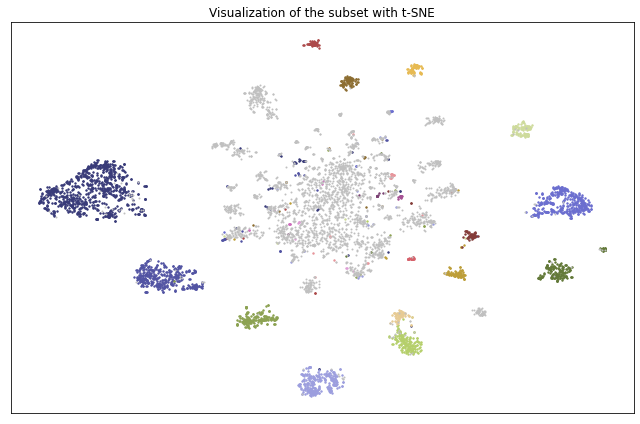

In [35]:
# Apply PCA to reduce the data to 50 components then TSNE
vec_PCA_lab = sklearn.decomposition.PCA(n_components=50).fit_transform(vec_hd[mask_labeled])
vec_PCA_all = sklearn.decomposition.PCA(n_components=50).fit_transform(vec_hd)

# Apply tSNE to plot
perplexity=50
n_iter = 2000
learning_rate = 200
#vec_2d_lab = sklearn.manifold.TSNE(n_components=2, perplexity=perplexity, learning_rate=200, \
#                               n_iter=n_iter, random_state=42, learning_rate=learning_rate, \
#                                  ).fit_transform(vec_PCA_lab)
vec_2d_all = sklearn.manifold.TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, \
                               n_iter=n_iter, random_state=42)\
                                .fit_transform(vec_PCA_all)

def plotClusters(vec_2d, labels, ax, param=None):
    mask_noise = (labels==-1) | (pd.isna(labels))
    unique_labels = [l for l, c in Counter(labels[~mask_noise]).most_common()]
    #colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(unique_labels)))
    colors = plt.cm.tab20b(np.linspace(0, 1, 20))
    
    for i in range(len(unique_labels)):
        mask = labels==unique_labels[i]
        ax.scatter(vec_2d[mask,0], vec_2d[mask,1], s=2, color=colors[i%20])
        
    ax.scatter(vec_2d[mask_noise,0], vec_2d[mask_noise,1], s=1, color='silver')
    ax.set(xticks=[], yticks=[])
    
    if param is not None:
        #ax.text(-50, -40, '%% cl = %.2f'%(param[0]), fontsize='large', ha='left')
        ax.text(-60, -60, 'k = %d'%(param[1]), fontsize='large', ha='left')
        ax.text(-50, -56, 'h = %.2f'%(param[2]), fontsize='large', ha='left')
        ax.text(-50, -64, 'c = %.2f'%(param[3]), fontsize='large', ha='left')

fig, ax = plt.subplots(figsize=(9,6))
plotClusters(vec_2d_all, df_sps_lab['sequence'].to_numpy(), ax, None)
ax.set(title='Visualization of the subset with t-SNE')
#plotClusters(vec_2d_lab, df_sps_lab.loc[mask_labeled,'sequence'].to_numpy(), axs[1], None)
plt.tight_layout()
plt.savefig(f'visualization/sequences_perplexity{perplexity}_niter{n_iter}_learningrate={learning_rate}.png', dpi=300)
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

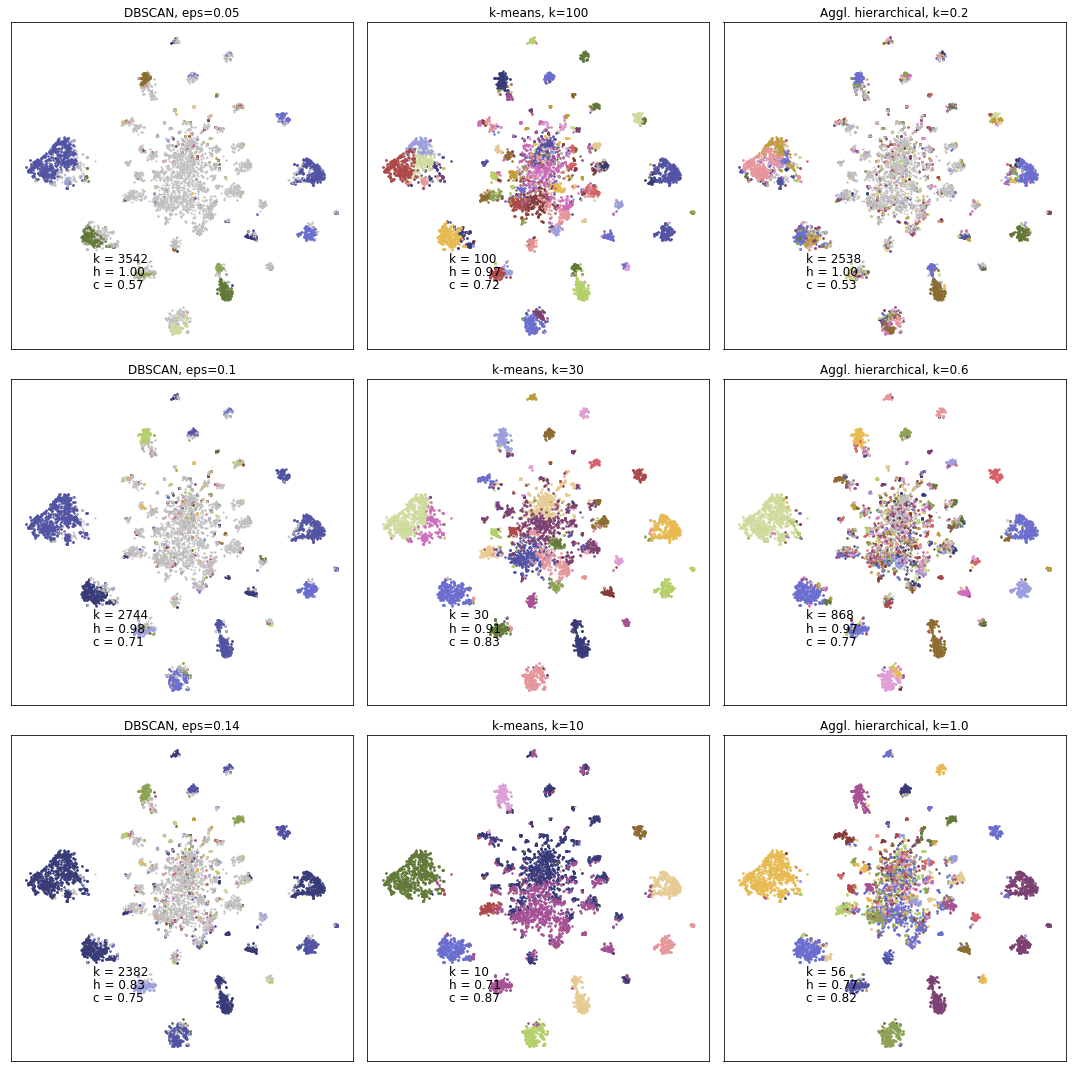

In [32]:
# Tag the singleton clusters as noise
def labelsToNoise(labels):
    for i in range(0, max(labels)+1):
        mask = labels==i
        if sum(mask) == 1:
            labels[mask] = -1
    return labels


def getMetrics(labels, sequences):
    labels = labelsToNoise(labels)
    mask_noise = labels==-1
    labels_reassign = np.copy(labels)
    labels_reassign[mask_noise] = np.arange(max(labels)+1, max(labels)+1+sum(mask_noise))
    
    mask_labels = (~pd.isna(sequences))
    h = sklearn.metrics.homogeneity_score(sequences[mask_labels], labels_reassign[mask_labels])
    c = sklearn.metrics.completeness_score(sequences[mask_labels], labels_reassign[mask_labels])
    prop_cl = sum(labels!=-1)/len(labels)
    
    unique_labels = set(labels_reassign.tolist())
    if -1 in unique_labels:
        unique_labels.remove(-1)
    k = len(unique_labels)

    return h, c, prop_cl, k



parameters = [[0.05, 100, 0.2],
              [0.1, 30, 0.6],
              [0.14, 10, 1.0]]
              
dim = (len(parameters), len(parameters[0]))
fig, axs = plt.subplots(dim[0], dim[1], figsize=(5*dim[1], 5*dim[0]))

for i in tqdm(range(len(parameters))):
    row = parameters[i]
    for j in range(3):
        if j==0: # Apply DBSCAN
            alg = 'DBSCAN'
            clust_labels = sklearn.cluster.DBSCAN(eps=row[j], min_samples=2, metric='cosine').fit(vec_ld).labels_
            axs[i,j].set(title=f'{alg}, eps={row[j]}')
        elif j==1:
            alg = 'k-means'
            clust_labels = sklearn.cluster.KMeans(n_clusters=row[j], init='k-means++', n_init=5, random_state=2).fit(vec_ld).labels_
            axs[i,j].set(title=f'{alg}, k={row[j]}')
        elif j==2:
            alg = 'Aggl. hierarchical'
            clust_labels = sklearn.cluster \
                            .AgglomerativeClustering(n_clusters=None, distance_threshold=row[j], 
                                                     linkage='complete', affinity='cosine') \
                            .fit(vec_ld).labels_
            axs[i,j].set(title=f'{alg}, k={row[j]}')
        
        h, c, prop_cl, k_nonnoise = getMetrics(clust_labels, df_sps_lab['sequence'])
        plotClusters(vec_2d_all, clust_labels, axs[i,j], (prop_cl, k_nonnoise, h, c))
        


plt.tight_layout()
plt.savefig('visualization/comparison_plot.png', dpi=300)
plt.show()


In [13]:
def getKMeansMetrics(n):
    k_all, metrics = np.linspace(1, 100, n).astype(int), []
    
    for k in tqdm(k_all, desc='k-means'):
        clust_labels = sklearn.cluster.KMeans(n_clusters=k, init='k-means++', n_init=5).fit(vec_ld).labels_
        metrics.append(getMetrics(clust_labels, df_sps_lab['sequence']))
    
    return k_all, metrics


def getDBSCANMetrics(n):
    eps_all, metrics = np.linspace(0.3, 0.01, n), []
    
    for eps in tqdm(eps_all, desc='DBSCAN'):
        clust_labels = sklearn.cluster.DBSCAN(eps=eps, min_samples=2, metric='cosine').fit(vec_ld).labels_
        metrics.append(getMetrics(clust_labels, df_sps_lab['sequence']))
        
    return eps_all, metrics


def getAgglMetrics(n):
    thr_all, metrics = np.linspace(1.0, 0.2, n), []
    
    for thr in tqdm(thr_all, desc='Agglomerative'):
        clust_labels = sklearn.cluster \
                            .AgglomerativeClustering(n_clusters=None, distance_threshold=thr, \
                                                     linkage='complete', affinity='cosine') \
                            .fit(vec_ld).labels_
        metrics.append(getMetrics(clust_labels, df_sps_lab['sequence']))

    return thr_all, metrics


875       VDSSNYDPFR
905       VDSSNYDPFR
918       VDSSNYDPFR
931       VDSSNYDPFR
932       VDSSNYDPFR
            ...     
24164    VVISIQITAEK
24178    VVISIQITAEK
24179    VVISIQITAEK
24181    VVISIQITAEK
24500    VVISIQITAEK
Name: sequence, Length: 3272, dtype: object
(3272,)
0.0 0.595958557339461


DBSCAN:   0%|          | 0/20 [00:00<?, ?it/s]

k-means:   0%|          | 0/20 [00:00<?, ?it/s]

Agglomerative:   0%|          | 0/20 [00:00<?, ?it/s]

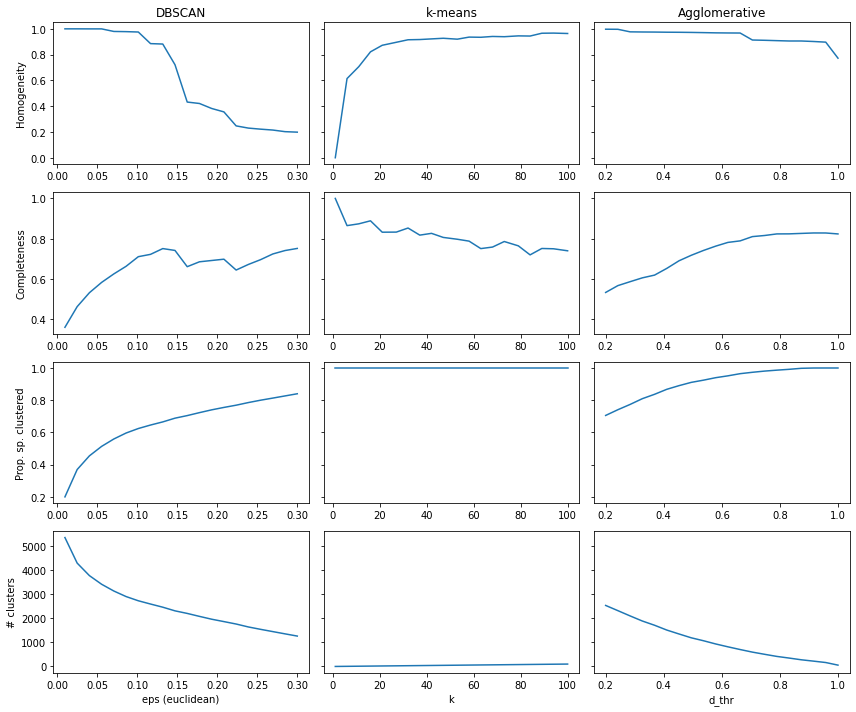

In [14]:



n = 20
metrics_all_algos = [('DBSCAN', getDBSCANMetrics(n), 'eps (euclidean)'),
                     ('k-means', getKMeansMetrics(n), 'k'),
                     ('Agglomerative', getAgglMetrics(n), 'd_thr')]

fig, axs = plt.subplots(4, 3, figsize=(12,10), sharey='row')
for i in range(len(metrics_all_algos)):   
    algo = metrics_all_algos[i][0]
    param, metrics = metrics_all_algos[i][1]
    param_name = metrics_all_algos[i][2]
    
    # Homogeneity
    h = [m[0] for m in metrics]
    axs[0,i].plot(param, h, label=algo)
    axs[0,i].set(title=algo)
    
    # Completeness
    c = [m[1] for m in metrics]
    axs[1,i].plot(param, c)
    
    # Prop clustered
    prop_cl = [m[2] for m in metrics]
    axs[2,i].plot(param, prop_cl)
    
    # k non noise
    k = [m[3] for m in metrics]
    axs[3,i].plot(param, k)
    axs[3,i].set(xlabel=param_name)
    
axs[0,0].set(ylabel='Homogeneity')
axs[1,0].set(ylabel='Completeness')
axs[2,0].set(ylabel='Prop. sp. clustered')
axs[3,0].set(ylabel='# clusters')
plt.tight_layout()
plt.savefig('visualization/comparison_all.png')
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

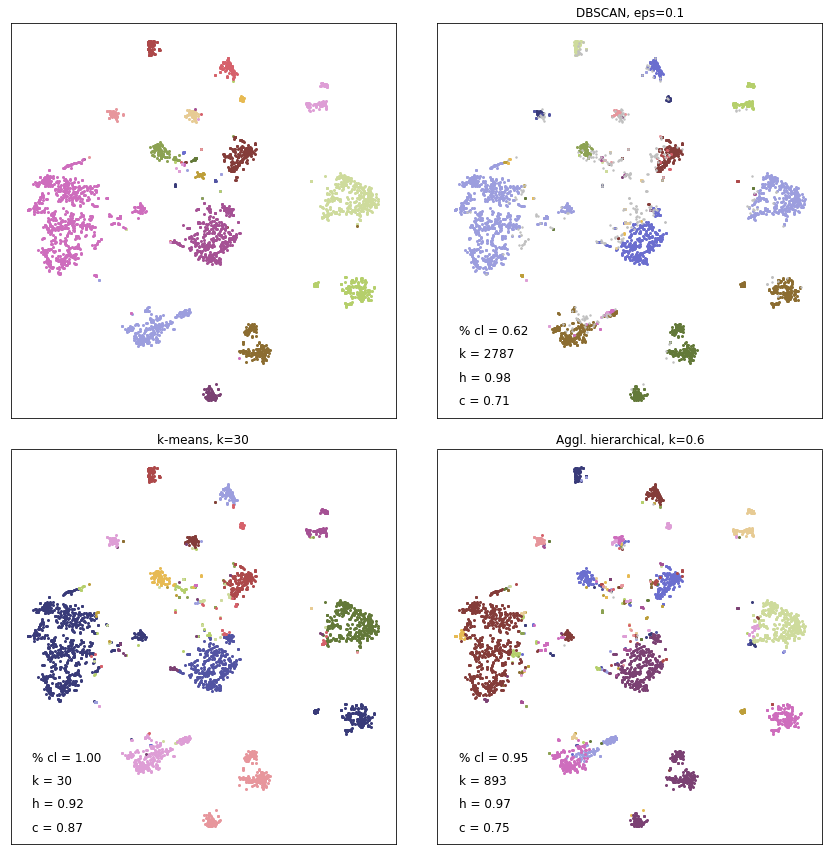

In [58]:
# Compare the 3 algos for their "best" parameters
fig, axs = plt.subplots(2, 2, figsize=(12,12))
plotClusters(vec_2d, df_sps_lab.loc[mask_labeled,'sequence'].to_numpy(), axs[0,0], None)
plt.tight_layout()

parameters = [0.1, 30, 0.6]
for i in tqdm(range(len(parameters))):
    p = parameters[i]
    
    if i==0: # Apply DBSCAN
        alg = 'DBSCAN'
        clust_labels = sklearn.cluster.DBSCAN(eps=p, min_samples=2, metric='cosine').fit(vec_ld).labels_
        h, c, prop_cl, k_nonnoise = getMetrics(clust_labels, df_sps_lab['sequence'])
        plotClusters(vec_2d, clust_labels[mask_labeled], axs[0,1], (prop_cl, k_nonnoise, h, c))
        axs[0,1].set(title=f'{alg}, eps={p}')
    elif i==1:
        alg = 'k-means'
        clust_labels = sklearn.cluster.KMeans(n_clusters=p, init='k-means++', n_init=5, random_state=2).fit(vec_ld).labels_
        h, c, prop_cl, k_nonnoise = getMetrics(clust_labels, df_sps_lab['sequence'])
        plotClusters(vec_2d, clust_labels[mask_labeled], axs[1,0], (prop_cl, k_nonnoise, h, c))
        axs[1,0].set(title=f'{alg}, k={p}')
    elif i==2:
        alg = 'Aggl. hierarchical'
        clust_labels = sklearn.cluster \
                        .AgglomerativeClustering(n_clusters=None, distance_threshold=p, 
                                                 linkage='complete', affinity='cosine') \
                        .fit(vec_ld).labels_
        h, c, prop_cl, k_nonnoise = getMetrics(clust_labels, df_sps_lab['sequence'])
        plotClusters(vec_2d, clust_labels[mask_labeled], axs[1,1], (prop_cl, k_nonnoise, h, c))
        axs[1,1].set(title=f'{alg}, k={p}')

    
plt.savefig(f'visualization/comp_bestparameters.png', dpi=300)  
plt.show()

### Check if close pairs tend to respect the precursor mass constraint

In [10]:
'''distances = []
precursormz = []

dist = sklearn.metrics.euclidean_distances(vec_ld)

for i in tqdm(range(len(sps))):
    for j in range(len(sps)):
        distances.append(dist[i,j])
        precursormz.append(abs(sps[i].precursor_mz - sps[j].precursor_mz))

distances = np.asarray(distances)
precursormz = np.asarray(precursormz)'''

'distances = []\nprecursormz = []\n\ndist = sklearn.metrics.euclidean_distances(vec_ld)\n\nfor i in tqdm(range(len(sps))):\n    for j in range(len(sps)):\n        distances.append(dist[i,j])\n        precursormz.append(abs(sps[i].precursor_mz - sps[j].precursor_mz))\n\ndistances = np.asarray(distances)\nprecursormz = np.asarray(precursormz)'

In [11]:
'''mask_close = distances<0.31
print('mz interval:', sps[0].precursor_mz, sps[-1].precursor_mz)
tol = sps[0].precursor_mz*20/10**6
print(sum(precursormz[mask_close] < tol) / sum(mask_close))
print(np.mean(precursormz[mask_close]))
print(np.mean(precursormz[~mask_close]))'''

"mask_close = distances<0.31\nprint('mz interval:', sps[0].precursor_mz, sps[-1].precursor_mz)\ntol = sps[0].precursor_mz*20/10**6\nprint(sum(precursormz[mask_close] < tol) / sum(mask_close))\nprint(np.mean(precursormz[mask_close]))\nprint(np.mean(precursormz[~mask_close]))"

### Compare three dimensionality reduction methods

In [4]:
# Compute the distances between vectors for the different methods
def getDistances(vec_hd, n_components):
    nsp = len(vec_hd)
    
    vec_falc = dr_utils.reduction_falcon(vec_hd, n_components)
    dist_falc = sklearn.metrics.pairwise.cosine_distances(vec_falc).reshape(nsp**2,1)
    
    vec_PCA = sklearn.decomposition.PCA(n_components=n_components).fit_transform(vec_hd)
    dist_PCA = sklearn.metrics.pairwise.cosine_distances(vec_PCA).reshape(nsp**2,1)
    
    vec_Gaussian = sklearn.random_projection.GaussianRandomProjection().fit_transform(vec_hd)
    dist_Gaussian = sklearn.metrics.pairwise.cosine_distances(vec_Gaussian).reshape(nsp**2,1)
    
    return dist_falc, dist_PCA, dist_Gaussian


distances = getDistances(vec_hd, 800)
print(distances)

  0%|          | 0/6548 [00:00<?, ?it/s]

KeyboardInterrupt: 